# Regresiones multivariadas y predicción

Vamos a utilizar un dataset descargado de Kaggle https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption
sobre consumo energético de alguna ciudad al norte de Marruecos

Las columnas tienen lo siguiente:
```
Date Time: Time window of ten minutes.
Temperature: Weather Temperature.
Humidity: Weather Humidity.
Wind Speed: Wind Speed.
General Diffuse Flows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
Diffuse Flows
Zone 1 Power Consumption
Zone 2 Power Consumption
Zone 3 Power Consumption
```

In [ ]:
import csv, os
import datetime

with open(os.path.join('..','..','Data','power-consumption','powerconsumption.csv')) as fp:
    reader = csv.reader(fp, delimiter= ',')
    dataset = []
    for row in reader:
        dataset.append(row)
dataset[:2]

[['Datetime',
  'Temperature',
  'Humidity',
  'WindSpeed',
  'GeneralDiffuseFlows',
  'DiffuseFlows',
  'PowerConsumption_Zone1',
  'PowerConsumption_Zone2',
  'PowerConsumption_Zone3'],
 ['1/1/2017 0:00',
  '6.559',
  '73.8',
  '0.083',
  '0.051',
  '0.119',
  '34055.6962',
  '16128.87538',
  '20240.96386']]

In [ ]:
headers = dataset[0]
timestamps = []
numerical_features = []
for d in dataset[1:]:
    timestamps.append(datetime.datetime.strptime(d[0], '%m/%d/%Y %H:%M'))
    numerical_features.append(d[1:])

In [ ]:
numerical_features = np.array(numerical_features, dtype=np.float32) # como float
numerical_features.shape

(52416, 8)

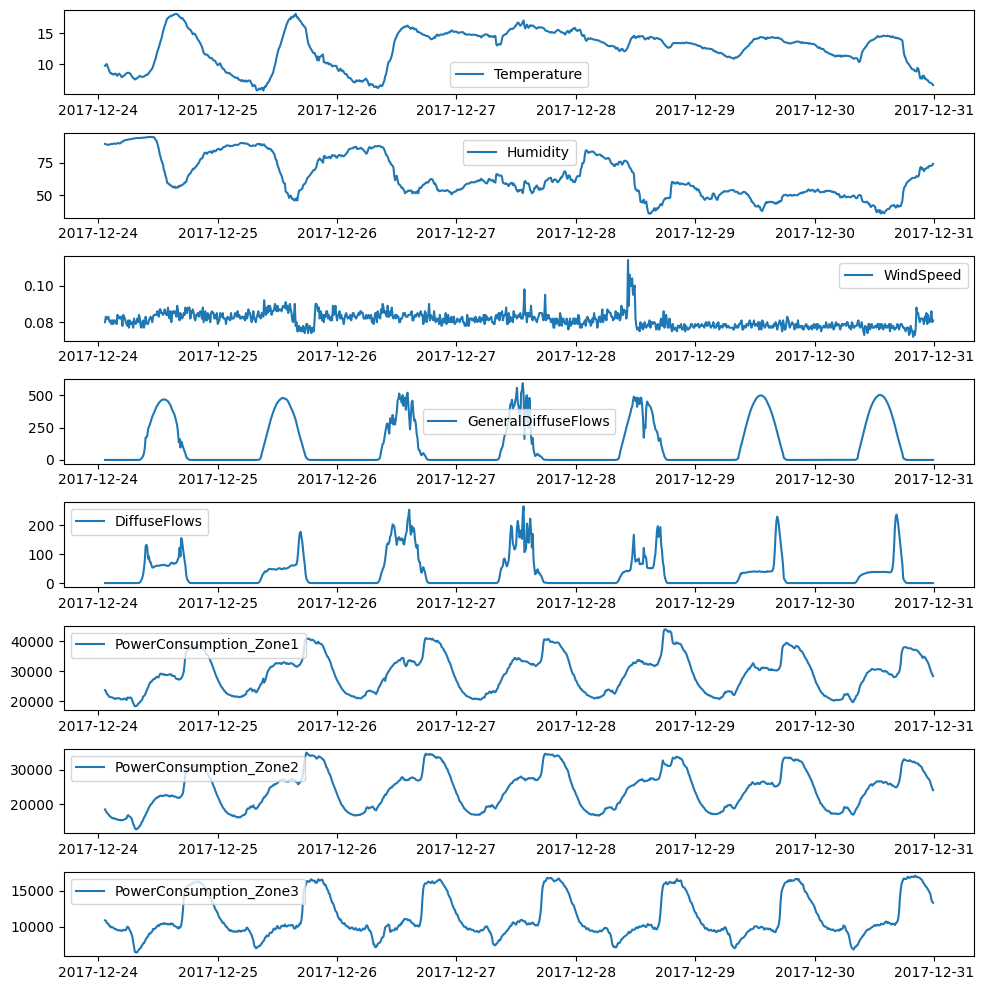

In [ ]:
# un plot para inspeccionar
fig, axs = plt.subplots(numerical_features.shape[1],1, figsize=(10,10))
for i in range(numerical_features.shape[1]):
    axs[i].plot(timestamps[-1000:], numerical_features[-1000:,i], label = headers[i+1])
    axs[i].legend()
fig.tight_layout()
plt.show()

### Qué resolver

Se pueden plantear muchos interrogantes para los datos previos, pero en este caso intentaremos predecir el consumo en las tres zonas medidas. 

En primer lugar se debe hacer un trabajo exploratorio de las diferentes variables, observar las correlaciones entre sí, extraer las estacionalidades y tendencias para tener un conjunto de datos más simples.

En este caso omitiremos ese análisis previo para mayor brevedad.

* __Problema 1__: Dadas las mediciones de Temp, hum, windspeed, Gen Diffuse Flows y Diffuse flows, predecir los consumos en las 3 regiones.

* __Problema 2__: A partir de las mediciones de todos los valores, predecir los valores siguientes de consumo en función de los previos

In [ ]:
# Problema 1. Vamos tomar datos al azar sin importar el tiempo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# normalizando los datos para que el modelo entrene mas rapido
scaler = StandardScaler()
scaled_set = scaler.fit_transform(numerical_features)

In [ ]:
# Separamos un conjunto de entrenamiento y otro de test
x_train, x_test, y_train, y_test = scaled_set[:-100,:5],scaled_set[-100:,:5], scaled_set[:-100,5:],scaled_set[-100:,5:]
# construimos los tensores correspondientes
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

In [ ]:
x_test.dtype

torch.float32

In [ ]:
# creamos un modelo simple
class RegresionMultivariada(torch.nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs) -> None:
        super().__init__()
        self.inp_linear = torch.nn.Linear(n_inputs, n_hidden)
        self.activation = torch.nn.ReLU()
        self.hidden_1 = torch.nn.Linear(n_hidden,n_hidden)
        self.out_linear = torch.nn.Linear(n_hidden, n_outputs)

    def forward(self, x):
        x = self.inp_linear(x)
        x = self.activation(x)
        x = self.hidden_1(x)
        x = self.activation(x)
        return self.out_linear(x)


In [ ]:
torch.manual_seed(0) # para reproducibilidad
model = RegresionMultivariada(5,64,3)
criterion = torch.nn.MSELoss() # Usamos MSE como loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
hist = []
for epoch in range(300):
    y_pred = model(x_train)
    loss = criterion(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        hist.append([loss.item(), criterion(y_test, model(x_test)).item()])
        if epoch %10 ==0:
            print(f'epoch: {epoch}/300 -- train loss: {loss.item()} -- test loss: { criterion(y_test, model(x_test)).item()}')

epoch: 0/300 -- train loss: 1.0062609910964966 -- test loss: 0.9432517290115356
epoch: 10/300 -- train loss: 0.8947392106056213 -- test loss: 1.151557445526123
epoch: 20/300 -- train loss: 0.8320937752723694 -- test loss: 1.2443896532058716
epoch: 30/300 -- train loss: 0.7910481095314026 -- test loss: 1.243574619293213
epoch: 40/300 -- train loss: 0.7673304677009583 -- test loss: 1.2051074504852295
epoch: 50/300 -- train loss: 0.7488663196563721 -- test loss: 1.1656553745269775
epoch: 60/300 -- train loss: 0.7356669306755066 -- test loss: 1.1488221883773804
epoch: 70/300 -- train loss: 0.7250784039497375 -- test loss: 1.1392534971237183
epoch: 80/300 -- train loss: 0.7155112624168396 -- test loss: 1.1131408214569092
epoch: 90/300 -- train loss: 0.70697021484375 -- test loss: 1.0973756313323975
epoch: 100/300 -- train loss: 0.6991870999336243 -- test loss: 1.087188720703125
epoch: 110/300 -- train loss: 0.6921321749687195 -- test loss: 1.080009937286377
epoch: 120/300 -- train loss: 0.6

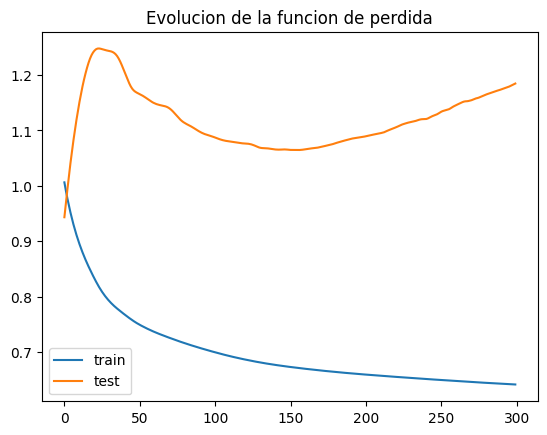

In [ ]:
plt.title('Evolucion de la funcion de perdida')
plt.plot([h[0]for h in hist], label = 'train')
plt.plot([h[1]for h in hist], label = 'test')
plt.legend()
plt.show()

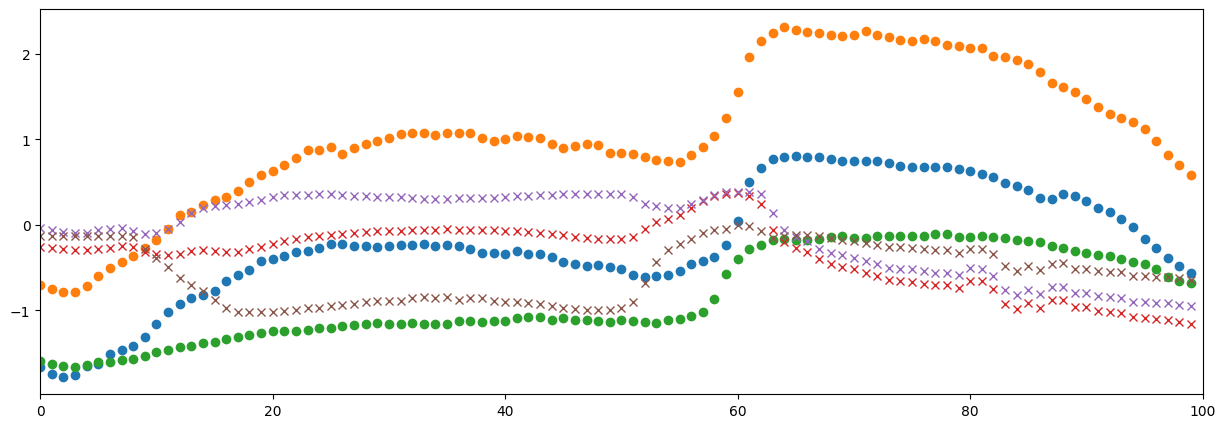

In [ ]:
plt.figure(figsize = (15,5))
plt.xlim(0,100)
plt.plot(y_test, 'o')
plt.plot(model(x_test).detach().numpy(), 'x')

El modelo es bastante pobre agregamos una capa oculta a ver si mejora

In [ ]:
# Mejoramos el modelo
# creamos un modelo simple
class RegresionMultivariada(torch.nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs) -> None:
        super().__init__()
        self.inp_linear = torch.nn.Linear(n_inputs, n_hidden)
        self.activation = torch.nn.ReLU()
        self.hidden_1 = torch.nn.Linear(n_hidden,n_hidden)
        self.hidden_2 = torch.nn.Linear(n_hidden,n_hidden//2)
        self.out_linear = torch.nn.Linear(n_hidden//2, n_outputs)

    def forward(self, x):
        x = self.inp_linear(x)
        x = self.activation(x)
        x = self.hidden_1(x)
        x = self.activation(x)
        x = self.hidden_2(x)
        x = self.activation(x)
        return self.out_linear(x)

In [ ]:
torch.manual_seed(0) # para reproducibilidad
model_2 = RegresionMultivariada(5,64,3)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [ ]:
hist = []
for epoch in range(300):
    y_pred = model(x_train)
    loss = criterion(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        hist.append([loss.item(), criterion(y_test, model(x_test)).item()])
        if epoch %10 ==0:
            print(f'epoch: {epoch}/300 -- train loss: {loss.item()} -- test loss: { criterion(y_test, model(x_test)).item()}')

epoch: 0/300 -- train loss: 0.6409615278244019 -- test loss: 1.2810100317001343
epoch: 10/300 -- train loss: 0.9197224378585815 -- test loss: 1.231727957725525
epoch: 20/300 -- train loss: 0.7486808896064758 -- test loss: 1.3079404830932617
epoch: 30/300 -- train loss: 0.7109637260437012 -- test loss: 1.210578441619873
epoch: 40/300 -- train loss: 0.689880907535553 -- test loss: 1.1605569124221802
epoch: 50/300 -- train loss: 0.6779528856277466 -- test loss: 1.140807032585144
epoch: 60/300 -- train loss: 0.6687694787979126 -- test loss: 1.1118402481079102
epoch: 70/300 -- train loss: 0.6636857390403748 -- test loss: 1.1235833168029785
epoch: 80/300 -- train loss: 0.6594522595405579 -- test loss: 1.1138328313827515
epoch: 90/300 -- train loss: 0.656096339225769 -- test loss: 1.1363787651062012
epoch: 100/300 -- train loss: 0.6531733870506287 -- test loss: 1.1404457092285156
epoch: 110/300 -- train loss: 0.6505724787712097 -- test loss: 1.153687596321106
epoch: 120/300 -- train loss: 0.6

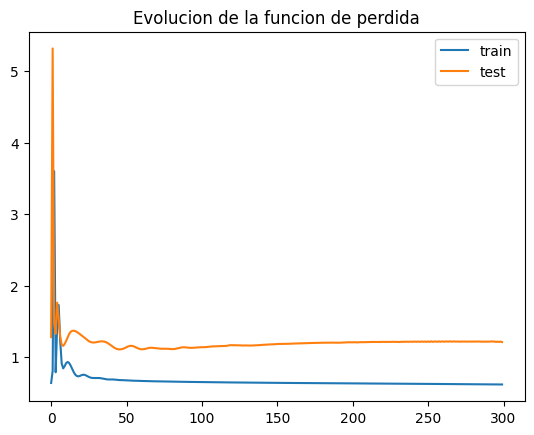

In [ ]:
plt.title('Evolucion de la funcion de perdida')
plt.plot([h[0]for h in hist], label = 'train')
plt.plot([h[1]for h in hist], label = 'test')
plt.legend()
plt.show()

In [ ]:
test = scaler.inverse_transform(np.hstack([x_test.numpy(),y_test.numpy()]))
pred = scaler.inverse_transform(np.hstack([x_test.numpy(),model(x_test).detach().numpy()]))

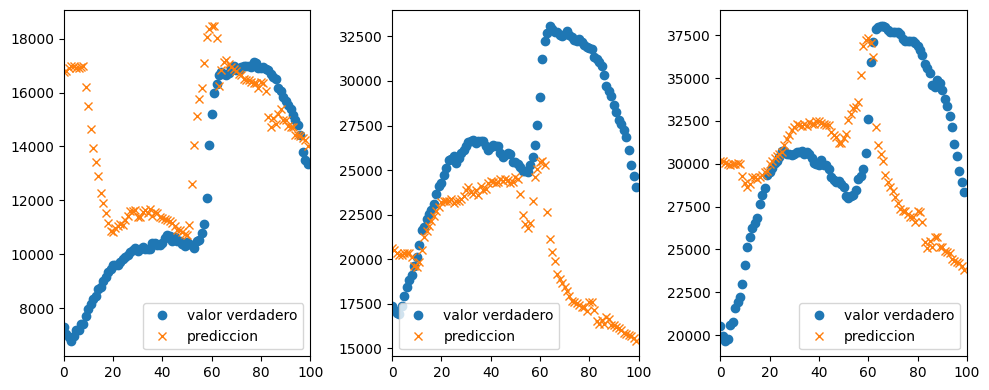

In [ ]:
fig, axs = plt.subplots(1,3,figsize =(10,4))
for i in range(1,4):
    axs[i-1].set_xlim(0,100)
    axs[i-1].plot(test[:,-i],'o', label = 'valor verdadero')
    axs[i-1].plot(pred[:,-i],'x', label = 'prediccion')
    axs[i-1].legend()
fig.tight_layout()

claramente el modelo es deficiente. Incorporaremos al tiempo como una variable para ver si se puede incorporar la periodicidad de las mediciones

In [ ]:
dt = [(timestamps[i+1]-timestamps[i]).seconds for i in range(len(timestamps)-1)]
print(f'media: {np.mean(dt)} - std: {np.std(dt)}')  # chequear que todos los datos estan equiespaciados

media: 600.0 - std: 0.0


In [ ]:
# Vamos a usar la cantidad de minutos del dia como otra variable para incluir el momento del dia como una feature
time = [t.minute + t.hour *60 for t in timestamps]
time = np.array(time, dtype=np.float32)

In [ ]:
# generamos un conjunto de entrenamiento y de testeo incluyendo a los minutos del dia

features = np.hstack([time.reshape(-1,1),scaled_set])
x_train, x_test, y_train, y_test = features[:-100,:6],features[-100:,:6], features[:-100,6:],features[-100:,6:]
# construimos los tensores correspondientes
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
print(x_train.shape)

torch.Size([52316, 6])


In [ ]:
torch.manual_seed(0) # para reproducibilidad
model_3 = RegresionMultivariada(6,64,3)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.02)
print(model_3)

RegresionMultivariada(
  (inp_linear): Linear(in_features=6, out_features=64, bias=True)
  (activation): ReLU()
  (hidden_1): Linear(in_features=64, out_features=64, bias=True)
  (hidden_2): Linear(in_features=64, out_features=32, bias=True)
  (out_linear): Linear(in_features=32, out_features=3, bias=True)
)


In [ ]:
hist = []
for epoch in range(300):
    y_pred = model_3(x_train)
    loss = criterion(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        hist.append([loss.item(), criterion(y_test, model_3(x_test)).item()])
        if epoch %10 ==0:
            print(f'epoch: {epoch}/300 -- train loss: {loss.item()} -- test loss: { criterion(y_test, model_3(x_test)).item()}')

epoch: 0/300 -- train loss: 105.3276596069336 -- test loss: 1167.9534912109375
epoch: 10/300 -- train loss: 2.595055341720581 -- test loss: 5.997880935668945
epoch: 20/300 -- train loss: 1.8398958444595337 -- test loss: 1.6259210109710693
epoch: 30/300 -- train loss: 1.8065179586410522 -- test loss: 1.8366918563842773
epoch: 40/300 -- train loss: 1.157173991203308 -- test loss: 1.5545625686645508
epoch: 50/300 -- train loss: 0.9419124126434326 -- test loss: 1.221442461013794
epoch: 60/300 -- train loss: 0.8728719353675842 -- test loss: 1.00172758102417
epoch: 70/300 -- train loss: 0.8616998195648193 -- test loss: 0.998918354511261
epoch: 80/300 -- train loss: 0.8395737409591675 -- test loss: 1.0420995950698853
epoch: 90/300 -- train loss: 0.8144456744194031 -- test loss: 1.0548269748687744
epoch: 100/300 -- train loss: 0.7779962420463562 -- test loss: 1.051275610923767
epoch: 110/300 -- train loss: 0.7180872559547424 -- test loss: 1.051163911819458
epoch: 120/300 -- train loss: 0.66804

El error cuadratico medio en el conjunto de test mejora bastante respecto de los modelos previos, pero aun asi es grande para los consumos escaleados. 

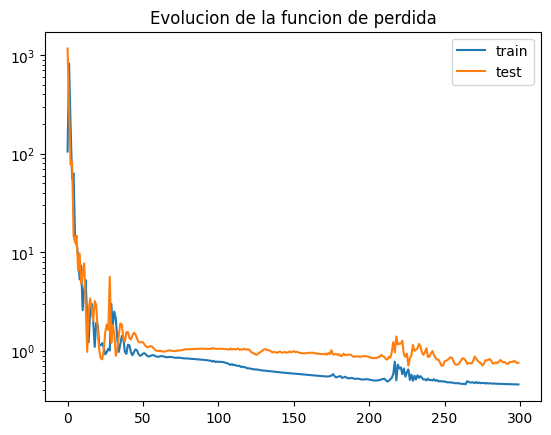

In [ ]:
plt.title('Evolucion de la funcion de perdida')
plt.semilogy([h[0]for h in hist], label = 'train')
plt.semilogy([h[1]for h in hist], label = 'test')
plt.legend()
plt.show()

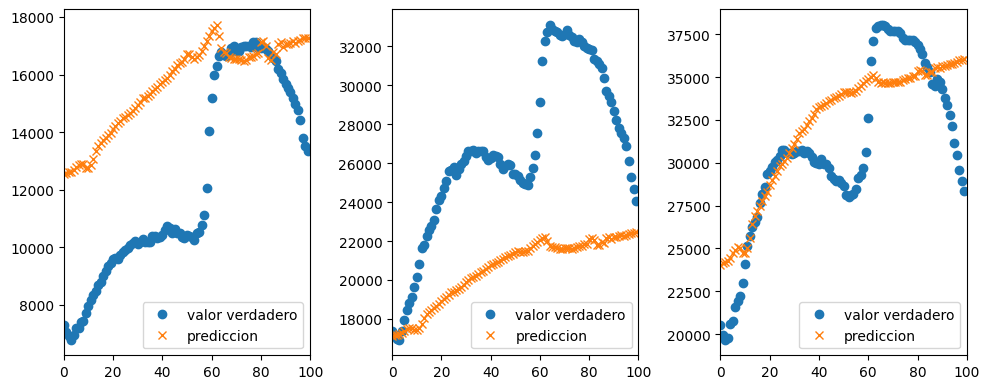

In [ ]:
test = scaler.inverse_transform(np.hstack([x_test[:,1:].numpy(),y_test.numpy()]))
pred = scaler.inverse_transform(np.hstack([x_test[:,1:].numpy(),model_3(x_test).detach().numpy()]))
fig, axs = plt.subplots(1,3,figsize =(10,4))
for i in range(1,4):
    axs[i-1].set_xlim(0,100)
    axs[i-1].plot(test[:,-i],'o', label = 'valor verdadero')
    axs[i-1].plot(pred[:,-i],'x', label = 'prediccion')
    axs[i-1].legend()
fig.tight_layout()

El modelo es incapaz de predecir a partir de las variables existentes los valores de consumo. En principio no parece se un problema de los modelos en si mismo, sino en que las variables medidas no son suficientes.

Para el problema previo, resulta importante hacer un analisis de componentes (que features son las importantes)

### Problema 2

Para encarar el problema 2, se debe entrenar al modelo de una manera particular. Supongamos que se quieren predecir los próximos $m$ consumos en términos de las $w$  mediciones a partir de un retardo (delay) $\delta$. 

en este caso las variables de entrada son:
$$
X = [X_{t-\delta-w},X_{t-\delta-(w-1)}, ..., X_{t-\delta}]
$$
y las salidas para cada uno de ellos
$$
y = [X^{pow}_{t}, X^{pow}_{t+1}, ... X^{pow}_{t+m}]
$$

El caso más simple es predecir los valores siguientes en términos del valor previo, $w=1$, $m=1$ y $\delta = 1$. Este modelo suele ser poco útil, pero se exlorará para comprender el funcionamiento.

En términos concretos, supongamos que quiero predecir un valor futuro de consumo ($m=1$) a partir de los $w = 120$ valores inmediatos previos, es decir  $\delta = 1$.

$$
X = [X_{t-121},X_{t-120}, ..., X_{t-1}]
$$
y las salidas para cada uno de ellos
$$
y = X^{pow}_{t}.
$$
En todas las anteriores el superíndice $\ ^{pow}$ hace referencia a las variables de consumo eléctrico únicamente


In [ ]:
def create_features(X, m = 1, w = 1, delay = 1):
    assert len(X) > m + w + delay, 'La serie es muy corta para los valores'

    train_x = []
    train_y = []
    for i in range(len(X)-w-delay-m+2):
        train_x.append(X[i : i +w])
        train_y.append(X[i+w+delay-1:i+w+delay+m-1,5:]) # solo los consumos 
    return np.array(train_x, dtype = np.float32), np.array(train_y, dtype=np.float32)

Este modelo presenta una nueva complicacion, que esta dada por la dimensionalidad del problema, por ejemplo si observamos un dato a futuro (m =1) con un delay de 10 minutos (delay=1), pero analizando una ventana de 2 horas (w = 12) nuestras variables de entrada tendran las siguientes dimensiones (n_samples, 12, 8), lo que significa que cada input es una matriz. El paquete torch.nn permite procesar los datos dentro del metodo forward como se desee, lo que lo hace sumamente poderoso. 

Si a una capa Linear(n_in, n_out) se le ingresa un tensor de cualquier forma, solo importa ultima dimension del tensor sea igual a n_in

> Una opcion es aplanar los w datos para cada feature y ponerlos a continuacion para pasarlos por una capa lineal y trabajar con ellos.

> Otra opcion es hacer alguna reduccion de los w datos (lo que pierde el sentido de orden).

### Manejo de datasets

Es posible que para un problema de muchas variables, y un dataset del tamaño aquí observado, no sea posible cargar todo el dataset y el modelo en memoria, por lo que se deberá trabajar por lotes (batches). PyToch provee una herramienta muy útil para manejar datasets grandes

Veamos estas herramientas

### Clase Dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
# Para las redes neuronales es mas simple ajustarse si los datos estan escalados
scaler = StandardScaler()
features_scaled = scaler.fit_transform(numerical_features)

x_train, y_train = create_features(features_scaled[:-100], m =1, w = 12, delay=1)
x_test, y_test = create_features(features_scaled[-100:], m =1, w = 12, delay=1)

In [ ]:
dataset_train = Dataset(x_train, y_train)
dataset_test = Dataset(x_test, y_test)
len(dataset_train)

52304

### Clase Dataloader

Esta clase crea los iteradores necesarios para trabajar por batches

In [ ]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size= 64, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size= 100, shuffle=True)

_x,_y = next(iter(dataloader_train))
_x.shape, _y.shape

(torch.Size([64, 12, 8]), torch.Size([64, 1, 3]))

In [ ]:
class RegLookback(torch.nn.Module):
    def __init__(self, n_in, n_hidden, lookback, n_out) -> None:
        super().__init__()
        self.linear = torch.nn.Linear(n_in*lookback, n_hidden)
        self.hidden = torch.nn.Linear(n_hidden, n_out)
        self.activation = torch.nn.ReLU()
    
    def forward(self, x):
        x = torch.flatten(x,start_dim=1)
        x = self.linear(x)
        x = self.activation(x)
        x = self.hidden(x)
        return x

In [ ]:
torch.manual_seed(0) # para reproducibilidad
regr_l1 = RegLookback(8,64,12,3)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(regr_l1.parameters(), lr=0.001)
print(regr_l1)

RegLookback(
  (linear): Linear(in_features=96, out_features=64, bias=True)
  (hidden): Linear(in_features=64, out_features=3, bias=True)
  (activation): ReLU()
)


In [ ]:
hist = []
n_epochs = 10
for epoch in range(n_epochs):        # train loop

    for x_b, y_b in dataloader_train:
        # forward pass
        y_pred = regr_l1(x_b)

        # loss calculation
        loss = criterion(y_b, y_pred)

        # backward
        optimizer.zero_grad()
        loss.backward()

        #update los pesos
        optimizer.step()

    with torch.no_grad():
        hist.append([loss.item(), criterion( next(iter(dataloader_test))[1], 
                                            regr_l1(next(iter(dataloader_test))[0])).item()])
        if epoch %1 ==0:
            print(f'epoch: {epoch}/{n_epochs} -- train loss: {hist[-1][0]} -- test loss: {hist[-1][1]}')

epoch: 0/10 -- train loss: 0.6246700882911682 -- test loss: 0.7920212745666504
epoch: 1/10 -- train loss: 0.5384934544563293 -- test loss: 0.768359363079071
epoch: 2/10 -- train loss: 1.0360536575317383 -- test loss: 0.7825183868408203
epoch: 3/10 -- train loss: 0.8169034123420715 -- test loss: 0.7656735181808472
epoch: 4/10 -- train loss: 0.9116184711456299 -- test loss: 0.7911444306373596
epoch: 5/10 -- train loss: 0.7997746467590332 -- test loss: 0.7813450694084167
epoch: 6/10 -- train loss: 0.777224600315094 -- test loss: 0.7693614959716797
epoch: 7/10 -- train loss: 0.8858053684234619 -- test loss: 0.7752847671508789
epoch: 8/10 -- train loss: 0.43158552050590515 -- test loss: 0.7805396914482117
epoch: 9/10 -- train loss: 0.6690892577171326 -- test loss: 0.7788652777671814


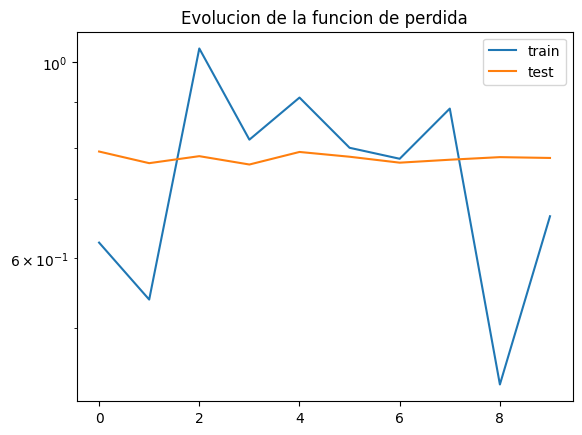

In [ ]:
plt.title('Evolucion de la funcion de perdida')
plt.semilogy([h[0]for h in hist], label = 'train')
plt.semilogy([h[1]for h in hist], label = 'test')
plt.legend()
plt.show()